In [20]:
%matplotlib inline
import random_forest as rf
import np_segment as nps
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
from sklearn.externals import joblib

## Demo of Segmenting Images

In [3]:
base_dir = os.getcwd()
data_dir = base_dir + '/demo_data/'

In [6]:
seg_regions = nps.segmentation_pipeline(data_dir,number_images=3)

/Users/cgroschner/Documents/pythonLearn/groschner-python-ay250-homework/final_project/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


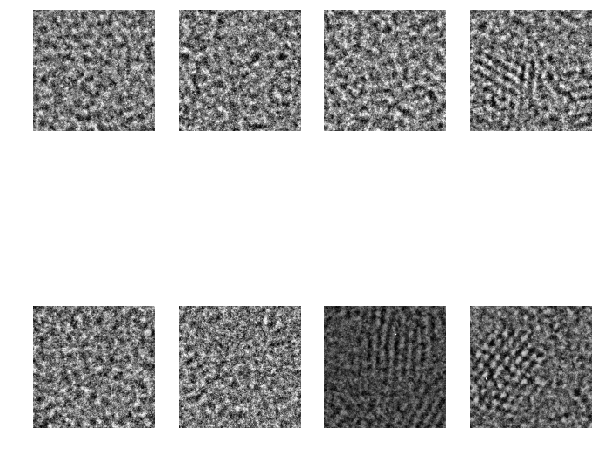

In [18]:
seg_image_files = glob(data_dir+'segmented_images/*.png')
fig, axs = plt.subplots(2,4,figsize = (10,10))
idx = 0
for row in axs:
    for ax in row:
        ax.imshow(io.imread(seg_image_files[idx]))
        ax.axis('off')
        idx += 1

Clearly the segmentation algorithm is not perfect however it did succesfully segment out three particles.

## Demo Classification

In [22]:
model_dir = base_dir + '/rf_models/'
filename = model_dir + 'opt_random_forest.pkl'
model = joblib.load(filename)